In [1]:
!pip install torch torchvision transformers
!nvidea-smi

/bin/bash: nvidea-smi: command not found


In [2]:
from torchvision.models import resnet50
from transformers import ResNetForImageClassification
import torch.nn as nn
from torchvision import datasets, transforms
import torch
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
model = resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s] 


In [4]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the entire dataset
dataset = datasets.ImageFolder(root='/kaggle/input/medical-previous-group/Medical Waste 4.0 (Previous group)', transform=transform)


total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.15 * total_size)
val_size = total_size - (train_size + test_size)  # Should be around 15% of the total

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [5]:
batch_size = 32  # Adjust as necessary

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [6]:
import torch.nn as nn

class CustomResNet(nn.Module):
    def __init__(self, original_model):
        super(CustomResNet, self).__init__()
        self.new_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding=1) # A tester sans cette couche
        self.resnet = nn.Sequential(*list(original_model.children())[:-1]) # Removing original FC layer

        # Add your new FC layer if necessary
        self.fc = nn.Linear(2048, num_classes) # num_classes is the number of your dataset classes

    def forward(self, x):
        x = self.new_layer(x)
        x = self.resnet(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        return x

# Initialize your custom model
num_classes = 13 # Example
custom_model = CustomResNet(model)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

custom_model.to(device)

params_to_optimize = custom_model.fc.parameters()



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_optimize, lr=1e-3)

num_epochs = 10

save_dir = "/content/saved_models"
os.makedirs(save_dir, exist_ok=True)

train_losses = []
val_losses = []
train_acc = []
val_acc = []

saved_models = []  # This list will hold the state dictionaries of the model

for epoch in range(num_epochs):
    # Variables to track progress within an epoch for training
    running_loss = 0.0
    correct_preds = 0
    total_train_preds = 0

    custom_model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = custom_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate the running loss and correct predictions
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_train_preds += labels.size(0)

    # Calculate and store training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_preds / total_train_preds
    train_losses.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # Variables to track progress within an epoch for validation
    val_loss = 0.0
    correct_preds = 0
    total_val_preds = 0

    # Validation phase
    custom_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = custom_model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate the validation loss and correct predictions
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_val_preds += labels.size(0)

    # Calculate and store validation loss and accuracy for the epoch
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = correct_preds / total_val_preds
    val_losses.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

     # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(custom_model.state_dict(), os.path.join(save_dir, f'custom_model_epoch_{epoch+1}.pt'))

    # Clear any outputs from the current cell display
    clear_output(wait=True)

    # Print the summary for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}]: '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

print("Summary after all epochs:")
print(f"{'Epoch':^5} | {'Train Loss':^10} | {'Train Acc':^9} | {'Val Loss':^9} | {'Val Acc':^8}")
print("-" * 50)
for i in range(num_epochs):
    print(f"{i+1:^5} | {train_losses[i]:^10.4f} | {train_acc[i]:^9.4f} | {val_losses[i]:^9.4f} | {val_acc[i]:^8.4f}")


Epoch [10/10]: Train Loss: 0.2092, Train Acc: 0.9371, Val Loss: 0.2370, Val Acc: 0.9060
Summary after all epochs:
Epoch | Train Loss | Train Acc | Val Loss  | Val Acc 
--------------------------------------------------
  1   |   1.2997   |  0.6372   |  0.6398   |  0.8386 
  2   |   0.5751   |  0.8310   |  0.3972   |  0.9201 
  3   |   0.4044   |  0.8886   |  0.3351   |  0.8997 
  4   |   0.3390   |  0.9034   |  0.3462   |  0.8793 
  5   |   0.2843   |  0.9236   |  0.2314   |  0.9498 
  6   |   0.2784   |  0.9118   |  0.2315   |  0.9310 
  7   |   0.2424   |  0.9236   |  0.2157   |  0.9326 
  8   |   0.2298   |  0.9286   |  0.1866   |  0.9561 
  9   |   0.2305   |  0.9206   |  0.2103   |  0.9389 
 10   |   0.2092   |  0.9371   |  0.2370   |  0.9060 


In [9]:
# Create a dictionary with your data
data = {
    "Epoch": list(range(1, num_epochs + 1)),
    "Training Loss": train_losses,
    "Training Accuracy": train_acc,
    "Validation Loss": val_losses,
    "Validation Accuracy": val_acc
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_file_path = '/kaggle/working/resnet_freezed_training_validation_metrics.csv'
df.to_csv(csv_file_path, index=False)

print(f"Metrics saved to {csv_file_path}")


Metrics saved to /kaggle/working/resnet_freezed_training_validation_metrics.csv


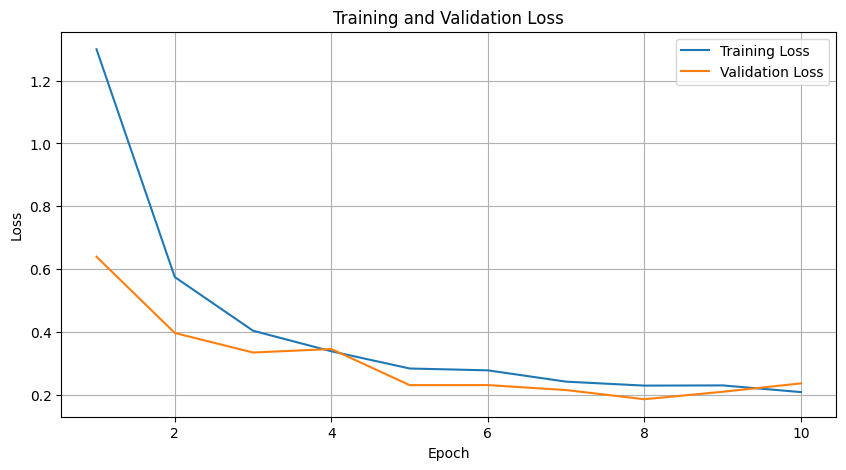

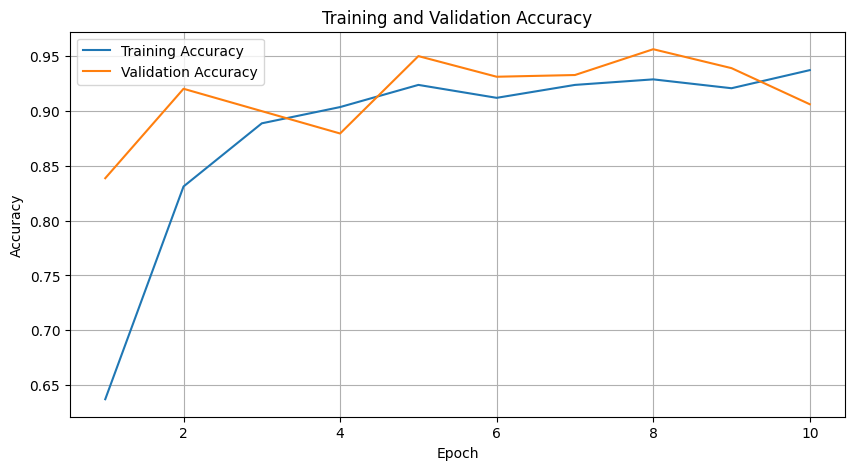

In [10]:
# Assuming num_epochs, train_losses, val_losses, train_acc, val_acc are defined and populated as before

# Plot for the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
torch.save(custom_model.state_dict(), '/kaggle/working/resnet_freezed_params.pt')

In [18]:
# Set up the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Assuming custom_model is already defined and loaded
custom_model.eval()

all_preds = []
all_labels = []

total_loss = 0.0
correct_preds = 0
total_samples = 0

# Disable gradient computation since it's not needed during testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = custom_model(inputs)
        loss = criterion(outputs, labels)

        # Loss calculation
        total_loss += loss.item() * inputs.size(0)

        # Accuracy calculation
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Save predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average loss and accuracy
avg_loss = total_loss / total_samples
accuracy = correct_preds / total_samples

print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.2826, Test Accuracy: 0.8868


In [22]:
# Data to save
data = {
    'Test Loss': [test_loss],
    'Test Accuracy': [test_accuracy]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV file
csv_file_path = '/kaggle/working/resnet_freezed_params_finetuning_test_results.csv'
df.to_csv(csv_file_path, index=False)

print(f'Test results saved to {csv_file_path}')

Test results saved to /kaggle/working/resnet_freezed_params_finetuning_test_results.csv


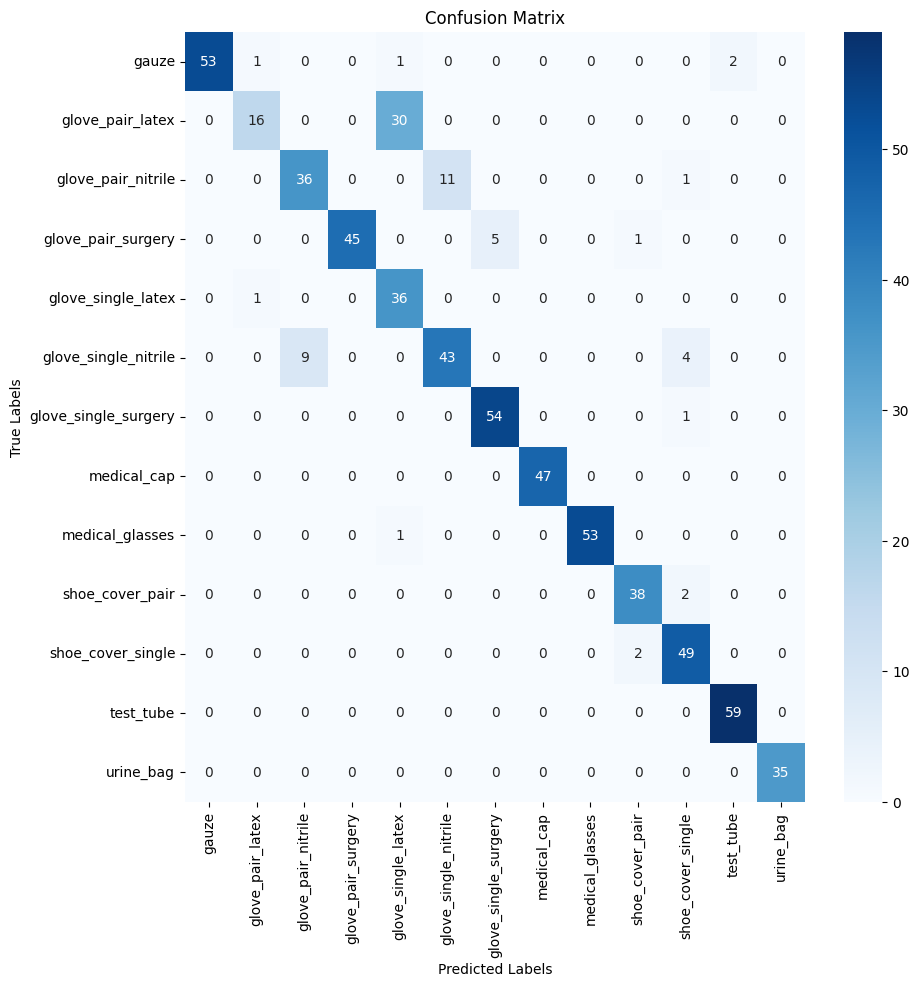

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = dataset.classes

# Plot the confusion matrix with class names
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()